After a meeting with HRG talking about the issues I've been facing with the microphone calibrations, some changes were suggested: 

    * use shorter tones (prev. 100ms tones, now 5ms)
    * check effect of having mic 'flush' on the wall, or slightly sticking out
    * use bigger 'wall' ( not yet implemented, as of 2021-05-04



In [1]:
import datetime as dt
import glob
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd
import soundfile as sf
import scipy.signal as signal 
from playback_code import playback_analysis as pa
from fullscale_calculations import *

In [2]:
print(f'This cell was run at: {dt.datetime.now()}')

This cell was run at: 2021-05-04 17:01:17.199220


In [3]:
%matplotlib notebook

In [4]:
def calculate_tones_rec_level(audio, fs, tone_freqs, FS_dbu, gain, sensitivity_dbvrms, freq_bw=500):
    '''
    '''
    
    audio_parts = np.array_split(audio, len(tone_freqs))
    
    tones_rms = []
    for peak_freq, audio_part in zip(tone_freqs, audio_parts):
        signal_fft = np.fft.fft(audio_part)
        fftfreqs = np.fft.fftfreq(audio_part.size, 1/fs)
        if np.logical_or(peak_freq<=0, peak_freq>=fs*0.5):
            raise ValueError(f'A peakfrequency <0 or > Nyquist frequency ({peak_freq}Hz) has been detected. Aborting....')
        signal_band = np.array([peak_freq-freq_bw, peak_freq+freq_bw])
        signal_band[signal_band<0] = 0
        signal_band[signal_band>fs*0.5] = fs*0.5
        rms_value = pa.extract_bandrms_from_fft(signal_band, signal_fft, fftfreqs)
        tones_rms.append(rms_value)
    
    #tones_rms = pa.get_tones_rms(audio, tone_freqs,fs=fs,bandwidth=freq_bw)
    tones_rms = pd.DataFrame(data={'tone_rms':tones_rms})
    max_rms = 1/(np.sqrt(2)) # for Vp=1 Vrms = (1/sqrt(2))*Vp
    tones_rms['dbrms_re_max'] = pa.dB(tones_rms['tone_rms']/max_rms)
    tones_rms['dbrms_wogain'] = tones_rms['dbrms_re_max']-gain
    tones_rms['db_FS'] = pa.dB(dbu2vrms(FS_dbu))
    tones_rms['tone_db'] = tones_rms['db_FS'] + tones_rms['dbrms_wogain']
    tones_rms['tone_freqs'] = tone_freqs
    sensitivity_vrms = 10**(sensitivity_dbvrms/20.0) # Vrms/Pa
    ref = 20*10**-6 # Pa

    tones_rms['Pa_rms'] = 10**(tones_rms['tone_db']/20.0)*(1/sensitivity_vrms)
    tones_rms['dbspl_rms'] = pa.dB(tones_rms['Pa_rms']/ref)
    return tones_rms

### Does the directionality match that of the data sheet? 


In [5]:
all_recs = glob.glob('2021-05-04/*.wav')
all_recs

['2021-05-04\\grasnowall-2m_gaindB_46_azimuth_angle_0_2021-05-04_13-45-43.wav',
 '2021-05-04\\grasnowall-2m_gaindB_46_azimuth_angle_0_2021-05-04_13-46-07.wav',
 '2021-05-04\\grasnowall-2m_gaindB_46_azimuth_angle_0_2021-05-04_13-49-10.wav',
 '2021-05-04\\grasnowall-2m_gaindB_46_azimuth_angle_30_2021-05-04_13-47-04.wav',
 '2021-05-04\\grasnowall-2m_gaindB_46_azimuth_angle_60_2021-05-04_13-47-50.wav',
 '2021-05-04\\grasnowall-2m_gaindB_46_azimuth_angle_90_2021-05-04_13-48-26.wav',
 '2021-05-04\\grasnowallfar_gaindB_46_azimuth_angle_0_2021-05-04_13-37-50.wav',
 '2021-05-04\\grasnowallfar_gaindB_46_azimuth_angle_0_2021-05-04_13-42-21.wav']

In [6]:
fireface_dbu_FS = 27
gras_dbVrmsPa = -49.17
gras_gain = 46
gras_datasheet_freqs = np.arange(20,90,10)*10**3

In [7]:
all_rec_data = []
for angle, filename in zip([0,30,60,90], all_recs[2:6]):
    audio, fs = sf.read(filename)

    tones = pa.get_only_tones(audio, 1.5)
    b,a = signal.butter(2, np.array([9000,95500])/(fs*0.5), 'bandpass')
    tones_bp = signal.lfilter(b,a,tones)

    freqs = np.arange(10000, 95000, 1000)

    tones_parts = np.array_split(tones_bp, 85)
    tones_level = calculate_tones_rec_level(tones_bp, fs, freqs, fireface_dbu_FS, gras_gain, gras_dbVrmsPa,freq_bw=250)

    relevant_rows = np.flatnonzero(np.isin(tones_level['tone_freqs'].to_numpy(),gras_datasheet_freqs))
    tones_data_subs = tones_level.loc[relevant_rows,['tone_freqs','dbspl_rms']]
    tones_data_subs['angle'] = angle
    all_rec_data.append(tones_data_subs)

<IPython.core.display.Javascript object>


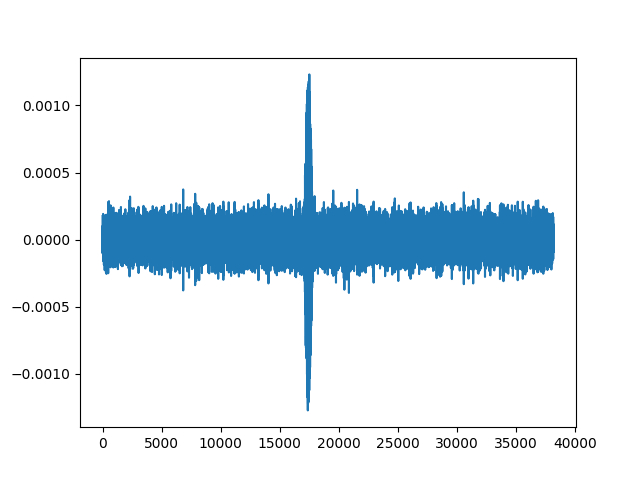

In [8]:
plt.figure()
plt.plot(tones_parts[1])

We'll calculate the background noise by looking at the dBrms SPL of the 0-9kHz bandwidth. 

In [9]:
bg_rms = pa.extract_inband_rms([0,9250],tones_bp,fs )
bg_dbrms_max = pa.dB(bg_rms/(1/np.sqrt(2)))
print(bg_dbrms_max)
# now convert the dBrms into dBspl to get the noise floor
bg_dbrms_nogain = bg_dbrms_max - 46
bg_db_reFS = pa.dB(dbu2vrms(27)) + bg_dbrms_nogain
bg_vrms = 10**(bg_db_reFS/20.0)

ref = 20*10**-6
sensitivity = 10**(-49.17/20.0) # vrms/pa
bg_dbspl = 20*np.log10((bg_vrms*(1/sensitivity))/(ref))
print(bg_dbspl)

-100.52753995717393
21.407894179672642


In [10]:
all_rec_data[0]

,tone_freqs,dbspl_rms,angle
10,20000,52.220268,0
20,30000,61.272777,0
30,40000,71.669644,0
40,50000,76.830164,0
50,60000,73.953713,0
60,70000,69.495578,0
70,80000,66.769621,0


In [11]:
gras_dirn = pd.read_csv('gras46bf_fromdatasheet.csv') # data digitised using WebPlotDigitizer
get_dbrange = lambda X : (np.max(X['rel_dB_onaxis'])-X['rel_dB_onaxis'])*-1
with_ranges = []
for freq, df in gras_dirn.groupby('freq_hz'):
    df['dbrange'] = get_dbrange(df)
    with_ranges.append(df)
    
gras_dirnlty = pd.concat(with_ranges)

In [12]:
all_rec_data = pd.concat(all_rec_data)

In [13]:
measured_gras_dirnlty = all_rec_data.copy()
ms_gras_angle = measured_gras_dirnlty.groupby('angle')
zero_deg_tiled  = np.tile(ms_gras_angle.get_group(0)['dbspl_rms'], 4)
measured_gras_dirnlty['norm_0_deg'] = measured_gras_dirnlty['dbspl_rms'] - zero_deg_tiled




<IPython.core.display.Javascript object>


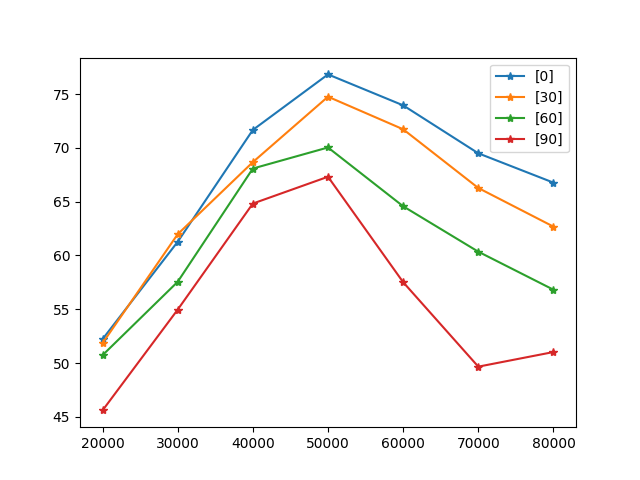

In [14]:
plt.figure()
for angle, df in all_rec_data.groupby('angle'):
    plt.plot(df['tone_freqs'], df['dbspl_rms'],'-*', label=str(np.unique(df['angle'])))
plt.legend()

<IPython.core.display.Javascript object>


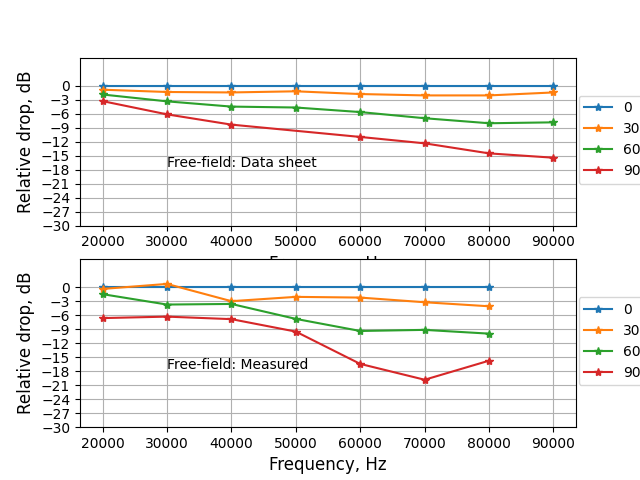

Text(30000, -17.5, 'Free-field: Measured')

In [15]:
plt.figure()
a1 = plt.subplot(211)
for angle, df in gras_dirnlty.groupby('angle_deg'):
    plt.plot(df['freq_hz'],df['dbrange'],'-*', label=angle)
plt.ylabel('Relative drop, dB', fontsize=12); plt.xlabel('Frequency, Hz', fontsize=12)
plt.legend(title='relative angle,$^{\circ}$');plt.grid();plt.ylim(-30,6)
a1.set_yticks(np.arange(-30,3,3));plt.legend(loc=(1.005125,0.25))
plt.text(30000, -17.5,'Free-field: Data sheet')
a2 = plt.subplot(212, sharex=a1)
for angle, df in measured_gras_dirnlty.groupby('angle'):
    plt.plot(df['tone_freqs'],df['norm_0_deg'],'-*', label=angle)
plt.ylabel('Relative drop, dB', fontsize=12); plt.xlabel('Frequency, Hz', fontsize=12)
plt.legend(title='relative angle,$^{\circ}$');plt.grid();plt.ylim(-30,6)
a2.set_yticks(np.arange(-30,3,3));plt.legend(loc=(1.005125,0.25))
plt.text(30000, -17.5,'Free-field: Measured')

### There's a decent match for 0-60deg. The match within 0-60deg is <1dB typically. At 90 degrees, the deviation increases strongly at 60, 70kHz , though it is actually still pretty good ($\leq$2dB) at the other frequencies. 

In [16]:
print(f'This cell was run at: {dt.datetime.now()}')

This cell was run at: 2021-05-04 17:01:23.601073
